# Content and Objective

+ Show estimation of channel impulse response
+ Method: Get know Tx signal and perform LS estimation by solving matrix-vector equation

In [1]:
# importing
import numpy as np
import scipy.signal
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(30, 8) )

# Parameters and Helper Function

In [3]:
########################
# generate output for a linear feedback shift register
#######################
def lfsr(taps, seed):
 
    ''' 
    Determines output of a linear feedback shift register (LFSR)
    
    NOTE: 
        - Exactly one period of length 2**n-1 is generated
        - in polynomial description LSB comes first
        - in taps LSB and MSB should equal 1
    
    IN: coefficients of the LFSR, seed
    OUT: 2**n-1 bits, representing one period of the LFSR
    '''

    assert( (taps[0] and taps[-1]) == 1), 'LSB and MSB of LFSR should equal 1! --> Exit'
    assert( len(taps)==len(seed)+1 ), 'Degree of feedback Taps should be number of cells +1!'

    n = len(seed)
    cells = np.array(seed, dtype=bool)    
    
    output = []
    k = 0
    
    while k < 2**n-1:
       #print k, [ int(c) for c in cells]
    
       output.append( int(cells[-1] ) )
       
       feedback = np.logical_and( cells, taps[1:] )
       
       cells = np.roll(cells, 1)
       cells[0] = sum( feedback ) % 2
       
       k += 1
    
    return np.array( output )

In [4]:
# modulation scheme and constellation points
constellation = np.array( [ 1 , -1] )

# generate PN sequence
pn_taps = [1, 0, 1, 0, 0, 1]      # mind that MSB (corresponding to the highest exponent) comes last
pn_seed = [0, 0, 0, 0, 1] 

pn = lfsr(pn_taps, pn_seed)  
pn_mod = constellation[ np.array( pn ) ]


# Get Random Channel Impulse Response

In [5]:
# define channel impulse response
N_h = 15 

h = np.random.randn(N_h) + 1j * np.random.randn(N_h)
h /= np.linalg.norm(h)


# Add Noise and Estimate

In [8]:
# define length of estimated impulse reponse and resulting convolution
# NOTE: Values not necessarily corresponding to true lengths
N_est = 25
N_conv_est = len( pn ) + N_est - 1


# define SNR in dB and get output signal
snr_db = 10

# get Tx signal and pad zeros if necessary due to wrong estimation length
x = np.convolve( pn_mod, h )
if N_conv_est > len(  x ):
    x = np.hstack( ( x, np.zeros( N_conv_est - len(x) ) ) )

# get output signal by adding noise
# Messwert!
sigma2 = 10 ** ( - snr_db / 10  )
y = x + np.sqrt( sigma2 / 2) * ( np.random.randn( len(x) ) + 1j * np.random.randn( len(x) ) )


# define transmission matrix
# NOTE: Notation as in the lecture slides
X = np.zeros( ( len(y), N_conv_est ) )

for k in np.arange(N_est):        
    X[ k : k + len( pn ), k] = pn_mod

    
# do channel estimation by LS estimation
h_est = np.dot( np.linalg.pinv(X), y ) # dot product pseudo inverse of x and y


# Show Results

Text(0.5, 1.0, 'SNR = 10 (dB)')

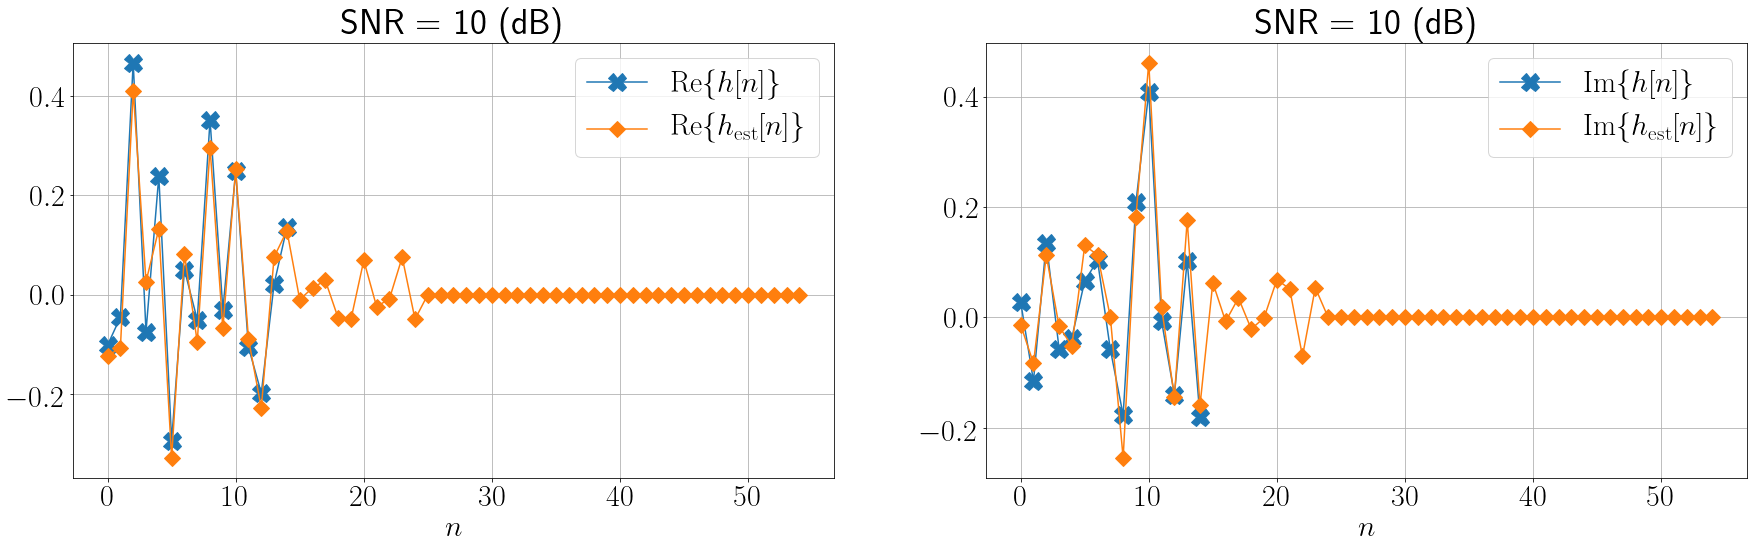

In [9]:
plt.figure()

plt.subplot(121)
plt.plot( np.real(h), '-X', ms=18, label='$\mathrm{Re}\{h[n]\}$' ) 
plt.plot( np.real(h_est), '-D', ms=12, label='$\mathrm{Re}\{h_{\mathrm{est}}[n]\}$') 
plt.grid(True)
plt.legend( loc='upper right' )
plt.xlabel('$n$')
plt.title('SNR = '+str(snr_db)+' (dB)')

plt.subplot(122)
plt.plot( np.imag(h), '-X', ms=18, label='$\mathrm{Im}\{h[n]\}$' ) 
plt.plot( np.imag(h_est), '-D', ms=12, label='$\mathrm{Im}\{h_{\mathrm{est}}[n]\}$') 
plt.grid(True)
plt.legend( loc='upper right' )
plt.xlabel('$n$')
plt.title('SNR = '+str(snr_db)+' (dB)')